In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.metrics import median_absolute_error
import random
import datetime

import tensorflow as tf
from tensorflow import keras
from tensorflow.python.keras.losses import LossFunctionWrapper
from tensorflow.python.keras.utils import losses_utils
import tensorflow_probability as tfp
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
tfd = tfp.distributions

import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px

!pip install -q -U keras-tuner

import keras_tuner as kt
import IPython

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

<div class="container-fluid">
    <img src="https://cdn.tv-programme.com/pic/episodes/38/387767.jpg" class="center-block">
    <div class="carousel-caption">
        <div class="page-header">
          <h1><p style="text-align: center; font-size:50px; color:#FFFFFF">N-BEATS </p><small STYLE='color:#FFFFFF; font-size:30px' >NEURAL BASIS EXPANSION ANALYSIS FOR
        INTERPRETABLE TIME SERIES horizonING
        </small></h1></div></div>
</div>

<h1 style="background-color: #428bca; color:#FFFFFF">Introduction</h1>

We will see in this notebook an implementation of N-BEATS model with keras and tensorflow and 3 examples!

This notebook is based on [N-BEATS: NEURAL BASIS EXPANSION ANALYSIS FOR INTERPRETABLE TIME SERIES horizonING](https://arxiv.org/abs/1905.10437)

> N-BEATS model is based on backward and forward residual links and a very deep stack of fully-connected layers. 
> Our architecture design methodology relies on a few key principles. First, the base architecture
should be simple and generic, yet expressive (deep). Second, the architecture should not rely on timeseries-specific feature engineering or input scaling. These prerequisites let us explore the potential
of pure DL architecture in TS horizoning. Finally, as a prerequisite to explore interpretability, the
architecture should be extendable towards making its outputs human interpretable. We now discuss
how those principles converge to the proposed architecture.

# Why this model?

Interpretable models are essential tools for the engineer. they can help to better understand interactions between variables and can discover really cool insights. This one is the deep learning version of other more traditional models based on trend and seasonality but gives better results. 

# Some informations
It has been declined in two versions: generic model and interpretable model. The first one works as a black box while the second describes the serie as a function of trend and seasonality. They give approximately same results but they offer better performances when coupled by bagging method.

# What will we do in this notebook?
We will demonstrate how to use the interpretable model (noted I) and how to tune it. Before diving into code details, let's focus on mathematics details and the overall structure.

<div class="alert alert-info" role="alert"> <a style="font-weight: bold;">Alert:</a> We slightly changed the implementation in order to integrate some additional stuffs.</div>



<h1 style="background-color: #428bca; color:#FFFFFF">Summary</h1>

<h3 style="text-indent: 5vw; font-family: Verdana; font-size: 15px; font-style: normal; font-weight: normal; text-decoration: none; text-transform: none; letter-spacing: 2px; color: navy; background-color: #ffffff;"> <a href="#a">I  &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Overall structure </a></h3>

---

<h3 style="text-indent: 5vw; font-family: Verdana; font-size: 15px; font-style: normal; font-weight: normal; text-decoration: none; text-transform: none; letter-spacing: 2px; color: navy; background-color: #ffffff;"> <a href="#b">II &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Trend </a></h3>

---

<h3 style="text-indent: 5vw; font-family: Verdana; font-size: 15px; font-style: normal; font-weight: normal; text-decoration: none; text-transform: none; letter-spacing: 2px; color: navy; background-color: #ffffff;"> <a href="#c">III&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Seasonality </a></h3>

---

<h3 style="text-indent: 5vw; font-family: Verdana; font-size: 15px; font-style: normal; font-weight: normal; text-decoration: none; text-transform: none; letter-spacing: 2px; color: navy; background-color: #ffffff;"> <a href="#d">IV &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Generic </a></h3>

--- 

<h3 style="text-indent: 5vw; font-family: Verdana; font-size: 15px; font-style: normal; font-weight: normal; text-decoration: none; text-transform: none; letter-spacing: 2px; color: navy; background-color: #ffffff;"> <a href="#e">V  &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Dropout </a></h3>

---

<h3 style="text-indent: 5vw; font-family: Verdana; font-size: 15px; font-style: normal; font-weight: normal; text-decoration: none; text-transform: none; letter-spacing: 2px; color: navy; background-color: #ffffff;"> <a href="#f">   &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Example 1: Temperature Change </a></h3>

---

<h3 style="text-indent: 5vw; font-family: Verdana; font-size: 15px; font-style: normal; font-weight: normal; text-decoration: none; text-transform: none; letter-spacing: 2px; color: navy; background-color: #ffffff;"> <a href="#h">   &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Example 2: U.S gaz </a></h3>

---

<h3 style="text-indent: 5vw; font-family: Verdana; font-size: 15px; font-style: normal; font-weight: normal; text-decoration: none; text-transform: none; letter-spacing: 2px; color: navy; background-color: #ffffff;"> <a href="#i">   &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Example 3: Covid vaccination </a></h3>


---

<h3 style="text-indent: 5vw; font-family: Verdana; font-size: 15px; font-style: normal; font-weight: normal; text-decoration: none; text-transform: none; letter-spacing: 2px; color: navy; background-color: #ffffff;"> <a href="#j">   &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Example 4: Ozone index </a></h3>

---

<h3 style="text-indent: 5vw; font-family: Verdana; font-size: 15px; font-style: normal; font-weight: normal; text-decoration: none; text-transform: none; letter-spacing: 2px; color: navy; background-color: #ffffff;"> <a href="#k">VI &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Conclusion </a></h3>

<h1 style="text-align: center; font-size:50px; background-color: #428bca; color:#FFFFFF"> Overall Structure </h1><a id=a></a>
<hr>

<div class="panel panel-default">
   <div class="panel-heading">Authors defined multiple loss functions to use with the model.</div>
    <div class="panel-body"> <p>However, we used the quantile loss error in order to estimate a prediction interval. This loss function is not really adapted here as it tends to zeros our weights, in order to prevent this phenomenom we squared the error.
</p>
<div class="list-group">
  <a href="https://en.wikipedia.org/wiki/Mean_absolute_percentage_error#:~:text=The%20mean%20absolute%20percentage%20error%20(MAPE),%20also%20known,loss%20function%20for%20regression%20problems%20in%20machine%20learning" class="list-group-item">MAPE</a>
  <a href="https://en.wikipedia.org/wiki/Symmetric_mean_absolute_percentage_error" class="list-group-item">SMAPE</a>
  <a href="https://en.wikipedia.org/wiki/Mean_absolute_scaled_error" class="list-group-item">MASE</a>
  <a href="https://arxiv.org/pdf/1905.10437.pdf" class="list-group-item">OWA</a>
  <a href="https://arxiv.org/abs/1912.09363v2" class="list-group-item">Quantile loss</a>
</div></div></div>

In [ ]:
"""Functions to assess loss."""

def quantile_loss(y_true, y_pred, quantiles):
    
    """Calculate the quantile loss function, summed across all quantile outputs.

    Parameters
    ----------
    y_true : ndarray or dataframe or list or Tensor of shape `[batch_size, d0, .. dN]`.
        Ground truth values.

    y_pred : ndarray or dataframe or list or Tensor of shape `[batch_size, d0, .. dN]`.
        The predicted values.

    n_quantiles : ndarray or dataframe or list or Tensor of shape `[batch_size, d0, .. dN]`.
        The set of output n_quantiles on which is calculated the quantile loss.

    Returns
    -------
    error : Tensor of shape `[batch_size, d0, .. dN]`.
        The error in %.
    """

    y_true = tf.cast(y_true, dtype=tf.float32)
    y_pred = tf.cast(y_pred, dtype=tf.float32)
    quantiles = tf.convert_to_tensor(quantiles)
    diff = tf.transpose(y_true - y_pred)

    quantile_loss = (quantiles * tf.clip_by_value(diff, 0., np.inf) +
                    (1 - quantiles) * tf.clip_by_value(-diff, 0., np.inf))
    
    M = tf.cast(tf.shape(y_true)[0], dtype=tf.float32)
    error = quantile_loss / M
    
    sum_quantiles = tf.reduce_sum(error, axis=-1)
    return tf.reduce_sum(sum_quantiles, axis=tf.range(sum_quantiles.shape.rank-1))

class QuantileLossError(LossFunctionWrapper):
    """Calculate the quantile loss error between `y_true`and `y_pred` across all examples.
    Standalone usage:
    >>> y_true = [[0., 1., 2.], [0., 0., 4.]]
    >>> y_pred = [[1., 1., 2.], [1., 0., 3.]]
    >>> # Using 'auto'/'sum_over_batch_size' reduction type.
    >>> ql = QuantileLossError(quantiles=[0.5])
    >>> ql(y_true, y_pred).numpy()
    0.5
    >>> # Calling with 'sample_weight'.
    >>> ql(y_true, y_pred, sample_weight=[0.7, 0.3]).numpy()
    0.25
    >>> # Using 'AUTO' reduction type.
    >>> ql = QuantileLossError(quantiles=[0.5],
    ...     reduction=tf.keras.losses.Reduction.AUTO)
    >>> ql(y_true, y_pred).numpy()
    0.25
    >>> # Using 'none' reduction type.
    >>> ql = QuantileLossError(quantiles=[0.5],
    ...     reduction=tf.keras.losses.Reduction.NONE)
    >>> ql(y_true, y_pred).numpy()
    array([0.25, 0.25], dtype=float32)
    >>> # Using multiple quantiles.
    >>> ql = QuantileLossError(quantiles=[0.1, 0.5, 0.9])
    >>> ql(y_true, y_pred).numpy()
    1.5

    Usage with the `compile()` API:
    ```python
    model.compile(optimizer='sgd', loss=tf.keras.losses.QuantileLossError())
    ```
    """

    def __init__(self,
                 quantiles,
                 reduction=losses_utils.ReductionV2.SUM,
                 name='quantile_loss'):
        super(QuantileLossError, self).__init__(
            quantile_loss, quantiles=quantiles, name=name, reduction=reduction)

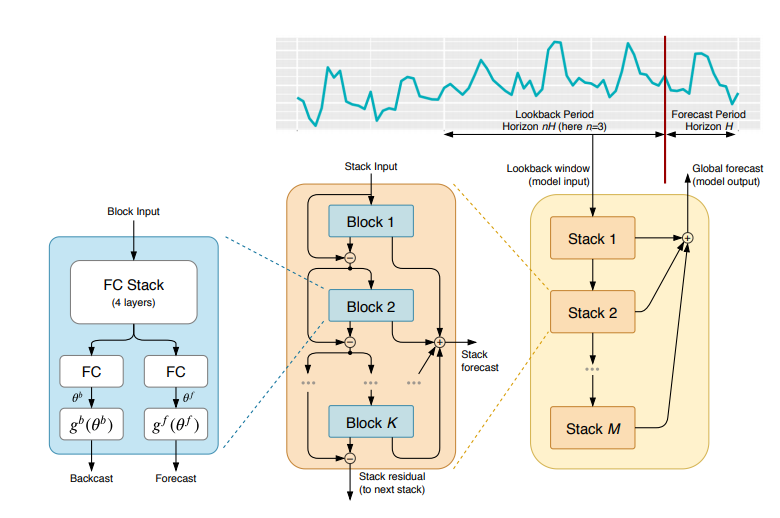 

<div class="alert alert-info" role="alert"> <a style="font-weight: bold;">Alert:</a> image taken from the research paper.</div>



<div align="justify">
    
# Let's start the notebook with the overall structure of the model.
    
As you can see in the previous image, we're dealing with a **deep residual Fully Connected model**. 
    
This is called **deep** because its internal layers are aggregated in blocks which themselves create stacks and all follow each other. 
    
This is called **residual** because every outputs are substract and used in a deeper part of the model but don't panic as we are introducing the interpretable model the structure won't be so deep.
    
# The input
The model is fed with a backcast period and predict a forecast period (also called back horizon and horizon). The recommanded equation between back horizon and horizon is:
</div>

<br>
<p style="text-align: center">$Back horizon = n \times horizon$
<br> With $n \in [1,...,7]$</p>

In case of few data, it's better to use back horizon = horizon (Personal experience).

We can define our input matrix with shape $(Batch\ size,\ back\ horizon)$

# Internal layers

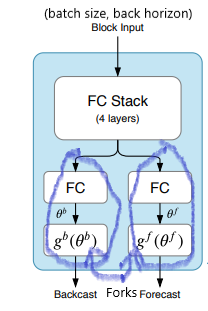

## What is a block ?

For sake of simplicity let's name a block **l**. We will use it to explain all the mathematical details as it is the same for every blocks.

A block is just 4 Fully Connected layers (called FC) which gives rise to two forks. The first way is trying to rebuild the back_horizon input while the second one is trying to predict the horizon. We find for each way a FC layer which gives birth to $\theta^f$ and $\theta^b$ coefficients.

They corresponds to expansion coefficients and they can be seen as the trend and seasonality coefficients. $g^b$ and $g^f$ are basis vectors. then a linear combination between coefficents and basis vectors is enough to create a prediction.  

## What is a stack ?

Only one block is enough to have a prediction so why is there more than one?
    
As explained before this is its residual property which gives its robustness. Multiple blocks aligned give better results, the following ones are trying to predict the missing part of their predecessors and finally outputs are sum up. 
    
These blocks give a stack and this is the sum of multiple stacks which gives the final output. 
So we end up with a global horizon of shape $(Batch\ size,\ horizon)$.

# Recommandations

Authors recommand to use 2 stacks with 3 blocks each (for I model). One stack representing the trend and a second corresponding to the seasonality. Also, the weights can be shared inside a same stack. We will focus on the composition of each interpretable block.</div>

The following cells gives you the overall structure code

In [ ]:
class Stack(tf.keras.layers.Layer):
    """A stack is a series of blocks where each block produce two outputs, the horizon and the back_horizon. 
    All of the outputs are sum up which compose the stack output while each residual back_horizon is given to the following block.
    
    Parameters
    ----------
    blocks: list of `TrendBlock`, `SeasonalityBlock` or `GenericBlock`.
        Define blocks in a stack.
    """
    def __init__(self, blocks, **kwargs):
        
        super().__init__(**kwargs)

        self._blocks = blocks

    def call(self, inputs):

        y_horizon = 0.
        for block in self._blocks:
            residual_y, y_back_horizon = block(inputs) # shape: (n_quantiles, Batch_size, horizon), (Batch_size, back_horizon)
            inputs = tf.subtract(inputs, y_back_horizon)
            y_horizon = tf.add(y_horizon, residual_y) # shape: (n_quantiles, Batch_size, horizon)

        return y_horizon, inputs

In [ ]:
class N_BEATS(tf.keras.Model):
    """This class compute the N-BEATS model. This is a univariate model which can be
     interpretable or generic. It's strong advantage is its internal structure which allows us 
     to extract the trend and the seasonality of a temporal serie. It's available from the attributes
     `seasonality` and `trend`. This is an unofficial implementation.

     `@inproceedings{
        Oreshkin2020:N-BEATS,
        title={{N-BEATS}: Neural basis expansion analysis for interpretable time series horizoning},
        author={Boris N. Oreshkin and Dmitri Carpov and Nicolas Chapados and Yoshua Bengio},
        booktitle={International Conference on Learning Representations},
        year={2020},
        url={https://openreview.net/forum?id=r1ecqn4YwB}
        }`
    
    Parameter
    ---------
    stacks: list of `Stack` layer.
        Define the stack to use in nbeats model. It can be full of `TrendBlock`, `SeasonalityBlock` or `GenereicBlock`.
    """
    def __init__(self, 
                 stacks,
                 **kwargs):
                
        super().__init__(**kwargs)

        self._stacks = stacks

    def call(self, inputs):
        self._residuals_y = tf.TensorArray(tf.float32, size=len(self._stacks)) # Stock trend and seasonality curves during inference
        y_horizon = 0.
        for idx, stack in enumerate(self._stacks):
            residual_y, inputs = stack(inputs)
            self._residuals_y.write(idx, residual_y)
            y_horizon = tf.add(y_horizon, residual_y)

        return y_horizon

    @property
    def seasonality(self):
        return self._residuals_y.stack()[1]

    @property
    def trend(self):
        return self._residuals_y.stack()[0]

<h2 style="text-align: center; font-size:50px; background-color: #428bca; color:#FFFFFF"> Trend </h2><a id=b></a>
<hr>

<h2 style="text-align: center; font-size:20px;"> What is the trend ? </h2><a id=b></a>

<center><img src="https://www.ezyeducation.co.uk/images/Lexicon_Images/trend_rate_growth.jpg"/></center>
The trend is often the first thing to be detected when analysing a time series. If you work in the fashion industry, you should know that this "trend" is the opposite of the ones you are familiar with, as it is an enduring phenomenon.

This is the general direction of a series of observations upwards or downwards over a fairly long period of time. When there is no direction, we say that there is no trend, which obviously does not mean that all values are the same...

Let us recall a basic rule for the study of economic time series. It is the analytical decomposition: chronicle = trend + periodic variations + random residual variations (+ possible economic cycle). This assumes a certain regularity. In a company, it is often an evolution of volumes observed over time. We will not mention here the particular case of stock market trends, studied in the context of technical analysis and on which statistically unpredictable movements are grafted...

<p align='justify'>
    As we have now the intuition about the trend, we understand why they are constraining layers $g^f$ and $g^b$. We have to mimic a monotonic function, or at least a slowly varying one. Authors then take a polynomial function of small degree p:
</p>

<p style="text-align: center" align='justify'>$\widehat{y}_{s,l}$$=\sum_{i=0}^p{\theta_{s,l,i}^i\times t^i}$
</p>

Matrix form: 
<p style="text-align: center" align='justify'>
$\widehat{y}_{s,l}$$=\theta_{s,l}^f T$</p>
    <br>
Our coefficents $\theta_{s,l}^f$ of shape $(batch\ size, p+1)$. 
    <br>
and T of shape $(p+1, horizon)$

\begin{equation*}
\theta^f_{s,l} = 
\begin{pmatrix}
\theta_{0,s,l,0} & \cdots & \theta_{0,s,l,p\ degree} \\
\vdots  & \vdots  & \ddots & \vdots  \\
\theta_{batch\ size,s,l,0} & \cdots & \theta_{batch\ size,s,l,p\ degree} \\
\end{pmatrix}
\end{equation*}

\begin{equation*}
T = 
\begin{pmatrix}
\frac{0^0}{H} \cdots & \cdots & \frac{(H-1)^0}{H}\\
\vdots  & \vdots  & \ddots & \vdots  \\
\frac{0^p}{H} \cdots & \cdots & \frac{(H-1)^p}{H}\\
\end{pmatrix}
\end{equation*}

Finally, our function is a matrix multiplication between a constrained g layers defined as the time steps and coefficients theta known as polynomial coefficients.

that's lead to $\widehat{y}$ of shape $(batch\ size, horizon)$


In [ ]:
class TrendBlock(tf.keras.layers.Layer):
    """ Trend block definition. Output layers are constrained which define polynomial function of small degree p.
    Therefore it is possible to get explanation from this block.
    
    Parameter
    ---------
    p_degree: integer
        Degree of the polynomial function.
    horizon: integer
        Horizon time to horizon.
    back_horizon: integer
        Past to rebuild.
    n_neurons: integer
        Number of neurons in Fully connected layers.
    n_quantiles: Integer.
        Number of quantiles in `QuantileLossError`.
    """
    def __init__(self, 
                 horizon, 
                 back_horizon,
                 p_degree,   
                 n_neurons, 
                 n_quantiles, 
                 dropout_rate,
                 **kwargs):

        super().__init__(**kwargs)
        
        self._p_degree = tf.reshape(tf.range(p_degree + 1, dtype='float32'), shape=(-1, 1)) # Shape (-1, 1) in order to broadcast horizon to all p degrees
        self._horizon = tf.cast(horizon, dtype='float32') 
        self._back_horizon = tf.cast(back_horizon, dtype='float32')
        self._n_neurons = n_neurons 
        self._n_quantiles = n_quantiles

        self._FC_stack = [tf.keras.layers.Dense(n_neurons, 
                                            activation='relu', 
                                            kernel_initializer="glorot_uniform") for _ in range(4)]
        
        self._dropout = tf.keras.layers.Dropout(dropout_rate)
        
        self._FC_back_horizon = self.add_weight(shape=(n_neurons, p_degree + 1), 
                                           trainable=True,
                                           initializer="glorot_uniform",
                                           name='FC_back_horizon_trend')
        
        self._FC_horizon = self.add_weight(shape=(n_quantiles, n_neurons, p_degree + 1),
                                           trainable=True,
                                           initializer="glorot_uniform",
                                           name='FC_horizon_trend')

        self._horizon_coef = (tf.range(self._horizon) / self._horizon) ** self._p_degree
        self._back_horizon_coef = (tf.range(self._back_horizon) / self._back_horizon) ** self._p_degree
        
    def call(self, inputs):

        for dense in self._FC_stack:
            x = dense(inputs) # shape: (Batch_size, n_neurons)
            x = self._dropout(x, training=True) # We bind first layers by a dropout 
            
        theta_back_horizon = x @ self._FC_back_horizon # shape: (Batch_size, p_degree)
        theta_horizon = x @ self._FC_horizon # shape: (n_quantiles, Batch_size, p_degree)

        y_back_horizon = theta_back_horizon @ self._back_horizon_coef # shape: (Batch_size, back_horizon)
        y_horizon = theta_horizon @ self._horizon_coef # shape: (n_quantiles, Batch_size, horizon)
        
        return y_horizon, y_back_horizon
    

<h2 style="text-align: center; font-size:50px; background-color: #428bca; color:#FFFFFF"> Seasonality </h2><a id=c></a>
<hr>


<center><img src="https://help.xlstat.com/servlet/rtaImage?eid=ka0080000002LJS&feoid=00N1p00000JrJra&refid=0EM08000002m1SU">
    
In statistical terms, the demand for - or sales of - a given product is said to exhibit seasonality when the underlying time series undergoes a predictable cyclical variation depending on the time of year. Seasonality is one of the most frequently used statistical behaviours to improve the accuracy of demand horizons.


In the same way as the trend we constrain $g^f$ and $g^b$. A natural choice for the basis to model periodic function is the Fourier series:

<p style="text-align: center" align='justify'>$\widehat{y}_{s,l}$$=\sum_{i=0}^{fourier\ order}{\theta_{s,l,i}^{f}\times \cos{2\pi i T}+\theta_{s,l,i+H/2}^{f}\times \sin{2\pi i T}}$</p>


$T=\frac{[0,1...,H-1]}{H}$ of shape $(, horizon)$
    <br>

Matrix form: 
<p style="text-align: center" align='justify'>
$\widehat{y}_{s,l}$$=\theta_{s,l}^fS$</p>

\begin{equation*}
\theta^f_{s,l} = 
\begin{pmatrix}
\theta_{0,s,l,0} & \theta_{0,s,l,1} & \cdots & \theta_{0,s,l,2 \times Fourier\ order} \\
\vdots  & \vdots  & \ddots & \vdots  \\
\theta_{batch\ size,s,l,0} & \theta_{batch\ size,s,l,1} & \cdots & \theta_{batch\ size,s,l,2 \times Fourier\ order} \\
\end{pmatrix}
\end{equation*}

\begin{equation*}
S = 
\begin{pmatrix}
\cos(2\pi\ \times 0\ \times 0/H) & \cdots & \cdots & \cos(2\pi\ \times 0\ \times H-1/H \\
\vdots  & \vdots  & \ddots & \vdots  \\
\cos(2\pi\ \times [\frac{H}{2}-1]\ \times0/H) & \cdots & \cdots & \cos(2\pi\ \times [\frac{H}{2}-1]\ \times H-1/H) \\
\sin(2\pi\ \times 0\ \times 0/H) & \cdots & \cdots & \sin(2\pi\ \times 0\ \times H-1/H) \\
\vdots  & \vdots  & \ddots & \vdots  \\
\sin(2\pi\ \times [\frac{H}{2}-1]\ \times 0/H) & \cdots & \cdots & \sin(2\pi\ \times [\frac{H}{2}-1]\ \times H-1/H) \\
\end{pmatrix}
\end{equation*}

<br>
with $\theta_{s,l}^f$ of shape $(batch\ size, fourier\ order)$ (In the paper fourier order = H/2).
    <br>

and S of shape $(2 \times fourier\ order, horizon)$. $2 \times fourier\ order$ because the matrix holds sin and cos coefficents. 

Leads to $\widehat{y}$ of shape $(batch\ size, horizon)$

We have modified the code so that the model integrates the possibility of adding seasonality periods and to modify the fourier order for each period. The linear nature of this model let us adding these features. Let's define p as the period and fourier_order the fourier order computed. 

Matrix become:

\begin{equation*}
\theta^f_{s,l} = 
\begin{pmatrix}
\theta_{0,s,l,period\ 1,0} & \cdots & \theta_{0,s,l,period\ 1,2 \times Fourier\ order}  & \cdots & \theta_{0,s,l,period\ n,2 \times Fourier\ order} \\
\vdots  & \vdots  & \ddots & \vdots  \\
\theta_{batch\ size,s,l,period\ 1,0} & \cdots & \theta_{batch\ size,s,l, period\ 1, 2 \times Fourier\ order} & \cdots & \theta_{batch\ size,s,l, period\ n, 2 \times Fourier\ order} \\
\end{pmatrix}
\end{equation*}

\begin{equation*}
S = 
\begin{pmatrix}
\cos(2\pi\ \times 0\ \times 0/H)_{period\ 1} & \cdots & \cdots & \cos(2\pi\ \times 0\ \times H-1/H)_{period\ 1} \\
\vdots  & \vdots  & \ddots & \vdots  \\
\cos(2\pi\ \times [\frac{H}{2}-1]\ \times 0/H)_{period\ 1}  & \cdots & \cdots & \cos(2\pi\ \times [\frac{H}{2}-1]\ \times H-1/H)_{period\ 1}  \\
\sin(2\pi\ \times 0\ \times 0/H)_{period\ 1}  & \cdots & \cdots & \sin(2\pi\ \times 0\ \times H-1/H)_{period\ 1}  \\
\vdots  & \vdots  & \ddots & \vdots  \\
\sin(2\pi\ \times [\frac{H}{2}-1]\ \times 0/H)_{period\ 1}  & \cdots & \cdots & \sin(2\pi\ \times [\frac{H}{2}-1]\ \times H-1/H)_{period\ 1}  \\
\vdots  & \vdots  & \ddots & \vdots  \\
\sin(2\pi\ \times [\frac{H}{2}-1]\ \times 0/H)_{period\ n}  & \cdots & \cdots & \sin(2\pi\ \times [\frac{H}{2}-1]\ \times H-1/H)_{period\ n}  \\
\end{pmatrix}
\end{equation*}

In [ ]:
class SeasonalityBlock(tf.keras.layers.Layer):
    """Seasonality block definition. Output layers are constrained which define fourier series. 
    Each expansion coefficent then become a coefficient of the fourier serie. As each block and each 
    stack outputs are sum up, we decided to introduce fourier order and multiple seasonality periods.
    Therefore it is possible to get explanation from this block.
    
    Parameters
    ----------
    horizon: integer
        Horizon time to horizon.
    back_horizon: integer
        Past to rebuild.
    n_neurons: integer
        Number of neurons in Fully connected layers.
    periods: Integer.
        fourier serie period. The paper set this parameter to `horizon/2`.
    back_periods: Integer.
        fourier serie back period. The paper set this parameter to `back_horizon/2`.
    horizon_fourier_order: Integer.
        Higher values signifies complex fourier serie
    back_horizon_fourier_order: Integer.
        Higher values signifies complex fourier serie
    n_quantiles: Integer.
        Number of quantiles in `QuantileLossError`.
    """
    def __init__(self,
                 horizon,
                 back_horizon,
                 n_neurons, 
                 periods, 
                 back_periods, 
                 horizon_fourier_order,
                 back_horizon_fourier_order,
                 n_quantiles,
                 dropout_rate,
                 **kwargs):
        
        super().__init__(**kwargs)

        self._horizon = horizon
        self._back_horizon = back_horizon
        self._periods = tf.cast(tf.reshape(periods, (1, -1)), 'float32') # Broadcast horizon on multiple periods
        self._back_periods = tf.cast(tf.reshape(back_periods, (1, -1)), 'float32')  # Broadcast back horizon on multiple periods
        self._horizon_fourier_order = tf.reshape(tf.range(horizon_fourier_order, dtype='float32'), shape=(-1, 1)) # Broadcast horizon on multiple fourier order
        self._back_horizon_fourier_order = tf.reshape(tf.range(back_horizon_fourier_order, dtype='float32'), shape=(-1, 1)) # Broadcast horizon on multiple fourier order

        # Workout the number of neurons needed to compute seasonality coefficients
        horizon_neurons = tf.reduce_sum(2 * horizon_fourier_order)
        back_horizon_neurons = tf.reduce_sum(2 * back_horizon_fourier_order)
        
        self._FC_stack = [tf.keras.layers.Dense(n_neurons, 
                                               activation='relu', 
                                               kernel_initializer="glorot_uniform") for _ in range(4)]
        
        self._dropout = tf.keras.layers.Dropout(dropout_rate)   
        
        self._FC_back_horizon = self.add_weight(shape=(n_neurons, back_horizon_neurons), 
                                           trainable=True,
                                           initializer="glorot_uniform",
                                           name='FC_back_horizon_seasonality')

        self._FC_horizon = self.add_weight(shape=(n_quantiles, n_neurons, horizon_neurons), 
                                           trainable=True,
                                           initializer="glorot_uniform",
                                           name='FC_horizon_seasonality')
        
        # Workout cos and sin seasonality coefficents
        time_horizon = tf.range(self._horizon, dtype='float32') / self._periods
        horizon_seasonality = 2 * np.pi * self._horizon_fourier_order * time_horizon
        self._horizon_coef = tf.concat((tf.cos(horizon_seasonality), 
                                          tf.sin(horizon_seasonality)), axis=0)

        time_back_horizon = tf.range(self._back_horizon, dtype='float32') / self._back_periods
        back_horizon_seasonality = 2 * np.pi * self._back_horizon_fourier_order * time_back_horizon
        self._back_horizon_coef = tf.concat((tf.cos(back_horizon_seasonality), 
                                        tf.sin(back_horizon_seasonality)), axis=0)
        
    def call(self, inputs):

        for dense in self._FC_stack:
            X = dense(inputs) # shape: (Batch_size, nb_neurons)
            X = self._dropout(X, training=True) # We bind first layers by a dropout 

        theta_horizon = X @ self._FC_horizon # shape: (n_quantiles, Batch_size, 2 * fourier order)
        theta_back_horizon = X @ self._FC_back_horizon # shape: (Batch_size, 2 * fourier order)
        
        y_horizon = theta_horizon @ self._horizon_coef # shape: (n_quantiles, Batch_size, horizon)
        y_back_horizon = theta_back_horizon @ self._back_horizon_coef # shape: (Batch_size, back_horizon)
    
        return y_horizon, y_back_horizon

<h2 style="text-align: center; font-size:50px; background-color: #428bca; color:#FFFFFF"> Generic </h2><a id=d></a>
<hr>

Few words for generic block. Contrary to trend and seasonality blocks, this one doesn't have contrained g function and then the output can't be interpreted.

In [ ]:
class GenericBlock(keras.layers.Layer):
    """
    Generic block definition as described in the paper. 
    We can't have explanation from this kind of block because g coefficients are learnt.
    
    Parameter
    ---------
    horizon: integer
        Horizon time to horizon.
    back_horizon: integer
        Past to rebuild.
    nb_neurons: integer
        Number of neurons in Fully connected layers.
    back_neurons: integer
        Number of back_horizon expansion coefficients.
    fore_neurons: integer
        Number of horizon expansion coefficients.
    """
    def __init__(self, horizon, 
                       back_horizon, 
                       n_neurons, 
                       n_quantiles,
                       dropout_rate,
                        **kwargs):
        
        super().__init__(**kwargs)
        
        self._FC_stack = [keras.layers.Dense(n_neurons, 
                                            activation='relu', 
                                            kernel_initializer="glorot_uniform") for _ in range(4)]
        
        self._dropout = tf.keras.layers.Dropout(dropout_rate)

        
        self._FC_back_horizon = self.add_weight(shape=(n_neurons, n_neurons), 
                                           trainable=True,
                                           initializer="glorot_uniform",
                                           name='FC_back_horizon_generic')

        self._FC_horizon = self.add_weight(shape=(n_quantiles, n_neurons, n_neurons), 
                                           trainable=True,
                                           initializer="glorot_uniform",
                                           name='FC_horizon_generic')
        
        self._back_horizon = keras.layers.Dense(back_horizon, 
                                           kernel_initializer="glorot_uniform")
        
        self._horizon = keras.layers.Dense(horizon, 
                                           kernel_initializer="glorot_uniform")
        
    def call(self, inputs):
        X = inputs # shape: (Batch_size, back_horizon)
        for dense_layer in self._FC_stack:
            X = dense_layer(X) # shape: (Batch_size, nb_neurons)
            X = self._dropout(X, training=True) # We bind first layers by a dropout 
            
        theta_horizon = X @ self._FC_horizon # shape: (n_quantiles, Batch_size, 2 * fourier order)
        theta_back_horizon = X @ self._FC_back_horizon # shape: (Batch_size, 2 * fourier order)
        
        y_back_horizon = self._back_horizon(theta_back_horizon) # shape: (Batch_size, back_horizon)
        y_horizon = self._horizon(theta_horizon) # shape: (n_quantiles, Batch_size, horizon)
        
        return y_horizon, y_back_horizon
    

<h2 style="text-align: center; font-size:50px; background-color: #428bca; color:#FFFFFF"> Epistemic and aleotoric error </h2><a id=e></a>
<hr>


<center><img src="https://1.bp.blogspot.com/-R7Ts4x5l6ew/X37AGoLiU1I/AAAAAAAAQWs/cM0W6FUOM34WzaAKppG5amRERuXVYgLWwCLcBGAsYHQ/s1200/1.jpeg">

We introduce dropout in order to regularize our model and to calculate uncertainty by keeping it active during inference. This is called confidence interval and it catched the epistemic errors which occur because our sample is not enough representative of the reality. This can be decreased thanks to new examples. 

However, the aleotoric error still exists. This is an irreductible fluctuation due to variables that we can't have access to, like error due to sensors. We can catch it by creating prediction intervals which can be estimated by using the Quantile loss error. I took it from the TFT paper: https://arxiv.org/abs/1912.09363v2

Bayesian model could have been used here, this may be the subject of a new version.

<h2 style="text-align: center; font-size:50px; background-color: #428bca; color:#FFFFFF"> Plot </h2><a id=e></a>
<hr>

The following cell defines the implementation of the plot function.

In [ ]:
def confidence_interval(time_series, quantile):
    
    mean = tf.reduce_mean(time_series, axis=0)
    standard_deviation = tf.math.reduce_std(time_series, axis=0)
    
    # (-1, 1, 1, 1) Broadcast std with shape (quantile, timesteps, horizon)
    max_interval = mean + tf.reshape(tfd.Normal(loc=0, scale=1).quantile(quantile), (-1, 1, 1, 1)) * standard_deviation 
    min_interval = mean - tf.reshape(tfd.Normal(loc=0, scale=1).quantile(quantile), (-1, 1, 1, 1)) * standard_deviation 
    
    return mean, min_interval, max_interval

def fig_add_trace(fig, y, x, row, col):
    for data, fill, name, color, showlegend in y:
        fig.add_trace(
            go.Scatter(
                name=name,
                x=x,
                y=data,
                fill=fill,
                line=dict(color=color),
                fillcolor=color,
                showlegend=showlegend),
            row=row, col=col)
        
def plot_results_nbeats(y_pred,
                        date_outputs,
                        y_true=None,
                        date_history=None,
                        seasonality=None,
                        trend=None):
    
    date = pd.to_datetime(date_outputs[0])
    date_history = date_history if date_history is not None else pd.to_datetime(date_outputs[0])
    y_pred_mean, y_pred_min_interval, y_pred_max_interval = confidence_interval(y_pred, [0.99])
    
    if trend is None:
        fig = make_subplots(
        subplot_titles=['True Vs Predicted','Trend','Seasonality', 'Overall trend', 'Overall seasonality'],
        rows=1, cols=1,
        vertical_spacing=0.1,
        horizontal_spacing=0.05,
        specs=[[{"type": "scatter"}]])
        
        if y_true is not None:
    
            # Trace ground truth
            fig.add_trace(
                    go.Scatter(
                        name="y_true",
                        x=date_history,
                        y=y_true[0],
                        line=dict(color="green")),
                    row=1, col=1
                )  
    
    else:
        fig = make_subplots(
        subplot_titles=['True Vs Predicted','Trend','Seasonality', 'Overall trend', 'Overall seasonality'],
        rows=3, cols=2,
        vertical_spacing=0.1,
        horizontal_spacing=0.05,
        column_widths=[0.8, 0.6],
        row_heights=[0.8, 0.8, 0.8],
        specs=[[{"type": "scatter", "rowspan": 2}, {"type": "scatter"}],
               [        None      , {"type": "scatter"}], 
               [{"type": "scatter", "colspan": 2}, None]])
        
        if y_true is not None:
    
            # Trace ground truth
            fig.add_trace(
                    go.Scatter(
                        name="y_true",
                        x=date_history,
                        y=y_true[0],
                        line=dict(color="green")),
                    row=1, col=1
                )  
            
        trend_mean, trend_min_interval, trend_max_interval = confidence_interval(trend, [0.99])

        fig_add_trace(fig, zip([trend_min_interval[0, 1, 0], trend_max_interval[0, 1, 0], 
                                trend_mean[1, 0]], 
                              ['none','tonextx', 'none'],
                              ['Confidence interval', 'Confidence interval', 'Average'],
                              ['rgba(153,50,204, 0.7)', 'rgba(153,50,204, 0.7)', 
                               'darkorange'], 
                              [ False, False, False]), date, row=1, col=2)
        
            # Trace mean
        fig_add_trace(fig, zip([tf.reduce_mean(trend_min_interval, axis=2)[0, 1], tf.reduce_mean(trend_max_interval, axis=2)[0, 1], 
                            tf.reduce_mean(trend_mean, axis=1)[1]], 
                          ['none','tonextx', 'none'],
                          ['Confidence interval', 'Confidence interval', 'Average'],
                          ['rgba(153,50,204, 0.7)', 'rgba(153,50,204, 0.7)', 
                           'darkorange'], 
                          [False, False, False]), date, row=3, col=1)
    
    # Trace mean
    fig_add_trace(fig, zip([y_pred_min_interval[0, 0, 0], y_pred_max_interval[0, 2, 0], 
                            y_pred_min_interval[0, 1, 0], y_pred_max_interval[0, 1, 0], 
                            y_pred_mean[1, 0]], 
                          ['none', 'tonextx', 'none','tonextx', 'none'],
                          ['Prediction interval', 'Prediction interval', 'Confidence interval', 'Confidence interval', 'Average'],
                          ['rgba(255, 0, 0, 0.2)', 'rgba(255, 0, 0, 0.2)', 
                           'rgba(153,50,204, 0.7)', 'rgba(153,50,204, 0.7)', 
                           'darkorange'], 
                          [False, True, False, True, True]), date, row=1, col=1)
    
    # Trace seasonality
    if seasonality is not None:
        seasonality_mean, seasonality_min_interval, seasonality_max_interval = confidence_interval(seasonality, [0.99])
        fig_add_trace(fig, zip([seasonality_min_interval[0, 1, 0], seasonality_max_interval[0, 1, 0], 
                                seasonality_mean[1, 0]], 
                              ['none','tonextx', 'none'],
                              ['Confidence interval', 'Confidence interval', 'Average'],
                              ['rgba(153,50,204, 0.7)', 'rgba(153,50,204, 0.7)', 
                               'darkorange'], 
                              [False, False, False]), date, row=2, col=2)
    
    return fig

<h2 style="text-align: center; font-size:50px; background-color: #428bca; color:#FFFFFF"> Dataset preprocessing </h2><a id=e></a>
<hr>

In [ ]:
class DataSet:
    """
    Preprocessing.
    """
    def __init__(self, horizon, back_horizon):
        self.horizon = horizon
        self.back_horizon = back_horizon
    
    def preprocessing(self, y, date, train_size=0.7, val_size=0.2):
        
        y = y.copy().astype('float')

        train = y[:int(train_size*len(y))]
        val = y[int(train_size*len(y))-self.back_horizon:int((train_size+val_size)*len(y))]
        test = y[int((train_size+val_size)*len(y))-self.back_horizon:]
        train_date = date[:int(train_size*len(y))]
        val_date = date[int(train_size*len(y))-self.back_horizon:int((train_size+val_size)*len(y))]
        test_date = date[int((train_size+val_size)*len(y))-self.back_horizon:]

        # Training set
        self.X_train, self.y_train, self.train_date = self.create_sequences(train, 
                                                                            train, 
                                                                            train_date,
                                                                            self.horizon, 
                                                                            self.back_horizon)
        # Validation set
        self.X_val, self.y_val, self.val_date = self.create_sequences(val,
                                                                      val,
                                                                      val_date,
                                                                      self.horizon,
                                                                      self.back_horizon)
        # Testing set
        self.X_test, self.y_test, self.test_date = self.create_sequences(test,
                                                                         test,
                                                                         test_date,
                                                                         self.horizon,
                                                                         self.back_horizon)

        # training on all database
        self.X_train_all, self.y_train_all, self.train_all_date = self.create_sequences(y, 
                                                                                        y,
                                                                                        date,
                                                                                        self.horizon,
                                                                                        self.back_horizon)
            
    @staticmethod
    def create_sequences(X, y, d, horizon, time_steps):
        Xs, ys, ds = [], [], []
        for col in range(X.shape[1]):
            for i in range(0, len(X)-time_steps-horizon, 1):
                Xs.append(X[i:(i+time_steps), col])
                ys.append(y[(i+time_steps):(i+time_steps+horizon), col])
                ds.append(d[(i+time_steps):(i+time_steps+horizon)])

        return np.array(Xs), np.array(ys), np.array(ds)

<h2 style="text-align: center; font-size:50px; background-color: #428bca; color:#FFFFFF"> NBEATS wrapper</h2><a id=e></a>
<hr>

This part defines wrapper to create generic model and interpretable model

In [ ]:
def create_interpretable_nbeats(horizon, 
                                   back_horizon,
                                   p_degree,   
                                   trend_n_neurons, 
                                   seasonality_n_neurons, 
                                   periods, 
                                   back_periods, 
                                   horizon_fourier_order,
                                   back_horizon_fourier_order,
                                   n_quantiles, 
                                   share=True,
                                   dropout_rate=0.1,
                                   **kwargs):
    
    """Wrapper to create interpretable model. check nbeats doc to know more about parameters."""
    
    if share is True:
        trend_block = TrendBlock(horizon=horizon, 
                                 back_horizon=back_horizon, 
                                 p_degree=p_degree, 
                                 n_neurons=trend_n_neurons, 
                                 n_quantiles=n_quantiles,
                                 dropout_rate=dropout_rate,
                                 **kwargs)
        
        seasonality_block = SeasonalityBlock(horizon=horizon, 
                                 back_horizon=back_horizon, 
                                 periods=periods, 
                                 back_periods=back_periods, 
                                 horizon_fourier_order=horizon_fourier_order,
                                 back_horizon_fourier_order = back_horizon_fourier_order,
                                 n_neurons=seasonality_n_neurons, 
                                 n_quantiles=n_quantiles,dropout_rate=dropout_rate, **kwargs)
        
        trendblocks = [trend_block for _ in range(3)]
        seasonalityblocks = [seasonality_block for _ in range(3)]
    else:
        trendblocks = [TrendBlock(horizon=horizon, 
                                 back_horizon=back_horizon, 
                                 p_degree=p_degree, 
                                 n_neurons=trend_n_neurons, 
                                 n_quantiles=n_quantiles, 
                                  dropout_rate=dropout_rate,
                                 **kwargs) for _ in range(3)]
        seasonalityblocks = [SeasonalityBlock(horizon=horizon, 
                                 back_horizon=back_horizon, 
                                 periods=periods, 
                                 back_periods=back_periods, 
                                 horizon_fourier_order=horizon_fourier_order,
                                 back_horizon_fourier_order = back_horizon_fourier_order,
                                 n_neurons=seasonality_n_neurons, 
                                 n_quantiles=n_quantiles,dropout_rate=dropout_rate, **kwargs) for _ in range(3)]
        
    trendstacks = Stack(trendblocks)
    seasonalitystacks = Stack(seasonalityblocks)
    
    return N_BEATS([trendstacks, seasonalitystacks])

def create_generic_nbeats(horizon,
                          back_horizon, 
                           n_neurons, 
                           n_quantiles,
                           n_blocks,
                           n_stacks,
                           share=True,
                           dropout_rate=0.1,
                           **kwargs):

    """Wrapper to create interpretable model. check nbeats doc to know more about parameters."""
    generic_stacks = []
    if share is True:
        for stack in range(n_stacks):
            generic_block = GenericBlock(horizon=horizon, 
                              back_horizon=back_horizon, 
                               n_neurons=n_neurons, 
                               n_quantiles=n_quantiles,
                               dropout_rate=0.1,
                               **kwargs)

            generic_blocks = [generic_block for _ in range(n_blocks)]
            generic_stacks.append(Stack(generic_blocks))
            
    else:
        for stack in range(n_stacks):
            generic_blocks = [GenericBlock(horizon=horizon, 
                              back_horizon=back_horizon, 
                               n_neurons=n_neurons, 
                               n_quantiles=n_quantiles, 
                               dropout_rate=0.1,
                               **kwargs) for _ in range(n_blocks)]
            
            generic_stacks.append(Stack(generic_blocks))
    
    return N_BEATS(generic_stacks)

<h2 style="text-align: center; font-size:50px; color:#428bca"> Example 1: Temperature change </h2><a id=f></a>
<hr>

Let's dive into the example, here we took temperature change over 50 years and 186 countries.

In [ ]:
data = pd.read_csv('/kaggle/input/temperature-change/Environment_Temperature_change_E_All_Data_NOFLAG.csv', encoding='latin', sep=',')
date = pd.date_range('1961-01-01', '2020-01-01', freq='M')

In [ ]:
# We are filtering on valid countries and months and rearranging the data to get df with shape (countries, months)

def preprocessing(element, data=data.copy()):
    df = []
    col = []
    for country in data['Area'].unique():
        new_data = data.dropna().query(f'Area=="{country}" & 7012>=`Months Code` & Element=="{element}"')    
        if len(new_data) == 12:
            col.append(country)
            df.append(new_data.iloc[:,7:].values.flatten('F'))

    df = pd.DataFrame(np.array(df).T, index=date, columns=col)
    return df
        
df = preprocessing("Temperature change")
df_std = preprocessing("Standard Deviation")

In [ ]:
fig = px.line(df, x=df.index, y=df.columns[0:],
              title='Temperature in °C over countries', width=1500)

fig.update_layout(
    updatemenus=[
        dict(
            active=0,
            buttons=list([dict(label="None",
                     method="update",
                     args=[{"visible": [True for _ in range(186)]},
                           {"title": "Temperature in °C over countries",
                            "annotations": []}])]) + list([
                dict(label=f"{j}",
                     method="update",
                     args=[{"visible": [True if i==idx else False for i in range(186)]},
                           {"title": f"{j}",
                            "annotations": []}]) for idx,j in enumerate(df.columns[0:])])
            )])

fig.show()

Let's take 120 months of horizon and a double of history.

In [ ]:
back_horizon = 2 * 120
horizon = 120

dataset = DataSet(horizon, back_horizon)
dataset.preprocessing(df.values, date, train_size=0.60, val_size=0.20)

Hypertuning of our model

In [ ]:
def model_builder(hp):
    
    hp_n_neurons_trend = hp.Int('neurons_trend', min_value = 4, max_value=16, step=2)
    hp_n_neurons_seas = hp.Int('neurons_seas', min_value = 4, max_value=16, step=2)
    hp_periods = hp.Int('periods', min_value = 1, max_value = horizon, step = 30)
    hp_back_periods = hp.Int('back_periods', min_value = 1, max_value = back_horizon, step = 30)
    hp_share = hp.Boolean('share')
    
    model_nbeats = create_interpretable_nbeats(horizon=horizon, 
                                               back_horizon=back_horizon,
                                               p_degree=1,   
                                               trend_n_neurons=hp_n_neurons_trend, 
                                               seasonality_n_neurons=hp_n_neurons_seas, 
                                               periods=hp_periods, 
                                               back_periods=hp_back_periods, 
                                               horizon_fourier_order=hp_periods,
                                               back_horizon_fourier_order=hp_back_periods,
                                               n_quantiles=3, 
                                               share=hp_share)

    model_nbeats.compile(loss=QuantileLossError([0.1, 0.5, 0.9]), optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                         metrics=[tf.keras.metrics.MeanAbsoluteError()])

    return model_nbeats

tuner = kt.Hyperband(model_builder,
                     objective = 'val_loss', 
                     max_epochs = 10,
                     factor = 3,
                     directory = 'my_dira',
                     project_name = 'temp')

class ClearTrainingOutput(tf.keras.callbacks.Callback):
    def on_train_end(*args, **kwargs):
        IPython.display.clear_output(wait = True)

tuner.search(dataset.X_train, dataset.y_train, epochs = 20, 
             validation_data = (dataset.X_val, dataset.y_val), callbacks = [ClearTrainingOutput()])

Training and test phase

In [ ]:
best_hps = tuner.get_best_hyperparameters(num_trials = 1)[0]

# Build the model with the optimal hyperparameters and train it on the data
model = tuner.hypermodel.build(best_hps)
model.build((None, back_horizon))
model.summary()

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=0.001)
es_cb = EarlyStopping(monitor='val_loss', min_delta=0,  patience=10, verbose=0, mode='auto', restore_best_weights=True)

history = model.fit(dataset.X_train, dataset.y_train, batch_size=64, epochs=20, 
                    callbacks = [reduce_lr, es_cb], validation_data = (dataset.X_val, dataset.y_val))


Loss curve during training

In [ ]:
fig = plt.figure(figsize=(20,5))

ax = plt.subplot(131)

epochs = [i for i in range(len(history.history['loss']))]
ax.plot(epochs, history.history['loss'], label='loss')
ax.plot(epochs, history.history['val_loss'], label='val_loss')
plt.legend()

ax = plt.subplot(132)
ax.plot(epochs, history.history['mean_absolute_error'], label='mean_absolute_error')
ax.plot(epochs, history.history['val_mean_absolute_error'], label='val_mean_absolute_error')
plt.legend()

ax = plt.subplot(133)
ax.plot(epochs, history.history['lr'], label='lr')
b = plt.legend()

We can then decompose our outputs. Here, the overall trend doesn't mean anything because multiple periods are taken into account.

In [ ]:
outputs = []
seasonality = []
trend = []
for sample in range(30):
    results = model(dataset.X_test)
    outputs.append(results)
    seasonality.append(model.seasonality)
    trend.append(model.trend)
    
plot_results_nbeats(y_pred=tf.stack(outputs),
                    date_outputs=dataset.test_date,
                    y_true=dataset.y_test,
                    date_history=None,
                    seasonality=tf.stack(seasonality),
                    trend=tf.stack(trend))

It's time for inference

In [ ]:
outputs = []
seasonality = []
trend = []
for sample in range(50):
    results = model(df.iloc[-240:].T.values)
    outputs.append(results)
    seasonality.append(model.seasonality)
    trend.append(model.trend)

In [ ]:
date_forecasting = np.expand_dims(pd.date_range('2020-01-01', '2030-01-01', freq='M'), axis=0)

plot_results_nbeats(y_pred=tf.stack(outputs),
                    date_outputs=date_forecasting,
                    y_true=df.T.values,
                    date_history=date,
                    seasonality=tf.stack(seasonality),
                    trend=tf.stack(trend))

From the previous graphs, we can see an overall increasing of the temperature of almost 0.5 degrees over 10 years. We can also check up the trend and seasonality curves of each country.

<h2 style="text-align: center; font-size:50px; color:#428bca"> Example 2: U.S gaz </h2><a id=h></a>
<hr>

Load data

In [ ]:
data_gaz = pd.read_csv('/kaggle/input/us-gasoline-and-diesel-retail-prices-19952021/PET_PRI_GND_DCUS_NUS_W.csv')
data_gaz.iloc[:, 0] = data_gaz.iloc[:, 0].astype('datetime64[ns]').dropna()
data = data_gaz.iloc[:, 1:]
date = data_gaz.iloc[:, 0]

In [ ]:
import plotly.express as px

fig = px.line(data_gaz, x='Date', y=data_gaz.columns[1:],
              hover_data={"Date": "|%B %d, %Y"},
              title='U.S Gaz over years')

fig.update_layout(
    updatemenus=[
        dict(
            active=0,
            buttons=list([dict(label="None",
                     method="update",
                     args=[{"visible": [True for _ in range(12)]},
                           {"title": "all U.S gaz over years",
                            "annotations": []}])]) + list([
                dict(label=f"{j}",
                     method="update",
                     args=[{"visible": [True if i==idx else False for i in range(12)]},
                           {"title": f"{j}",
                            "annotations": []}]) for idx,j in enumerate(data.columns[1:])])
            )])

fig.show()

We define horizon and back_horizon (1 year = 52 weeks)

In [ ]:
back_horizon = 3 * 52
horizon = 52

dataset = DataSet(horizon, back_horizon)
dataset.preprocessing(data.values, date, train_size=0.6, val_size=0.2)

In [ ]:
def model_builder(hp):
    
    hp_n_neurons_trend = hp.Int('neurons_trend', min_value = 4, max_value=16, step=2)
    hp_n_neurons_seas = hp.Int('neurons_seas', min_value = 4, max_value=16, step=2)
    hp_periods = hp.Int('periods', min_value = 1, max_value = horizon, step = 30)
    hp_back_periods = hp.Int('back_periods', min_value = 1, max_value = back_horizon, step = 30)
    hp_share = hp.Boolean('share')
    
    model_nbeats = create_interpretable_nbeats(horizon=horizon, 
                                               back_horizon=back_horizon,
                                               p_degree=1,   
                                               trend_n_neurons=hp_n_neurons_trend, 
                                               seasonality_n_neurons=hp_n_neurons_seas, 
                                               periods=hp_periods, 
                                               back_periods=hp_back_periods, 
                                               horizon_fourier_order=hp_periods,
                                               back_horizon_fourier_order=hp_back_periods,
                                               n_quantiles=3, 
                                               share=hp_share)

    model_nbeats.compile(loss=QuantileLossError([0.1, 0.5, 0.9]), optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                         metrics=[tf.keras.metrics.MeanAbsoluteError()])

    return model_nbeats

tuner = kt.Hyperband(model_builder,
                     objective = 'val_mean_absolute_error', 
                     max_epochs = 10,
                     factor = 3,
                     directory = 'my_dir',
                     project_name = 'gaz')

class ClearTrainingOutput(tf.keras.callbacks.Callback):
    def on_train_end(*args, **kwargs):
        IPython.display.clear_output(wait = True)

tuner.search(dataset.X_train, dataset.y_train, epochs = 20, 
             validation_data = (dataset.X_val, dataset.y_val), callbacks = [ClearTrainingOutput()])

In [ ]:
best_hps = tuner.get_best_hyperparameters(num_trials = 1)[0]

# Build the model with the optimal hyperparameters and train it on the data
model = tuner.hypermodel.build(best_hps)
model.build((None, back_horizon))
model.summary()

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=0.001)
es_cb = EarlyStopping(monitor='val_loss', min_delta=0,  patience=10, verbose=0, mode='auto', restore_best_weights=True)

history = model.fit(dataset.X_train, dataset.y_train, batch_size=64, epochs=10, 
                    callbacks = [reduce_lr, es_cb], validation_data = (dataset.X_val, dataset.y_val))


Loss curves of the training

In [ ]:
fig = plt.figure(figsize=(20,5))

ax = plt.subplot(131)

epochs = [i for i in range(len(history.history['loss']))]
ax.plot(epochs, history.history['loss'], label='loss')
ax.plot(epochs, history.history['val_loss'], label='val_loss')
plt.legend()

ax = plt.subplot(132)
ax.plot(epochs, history.history['mean_absolute_error'], label='mean_absolute_error')
ax.plot(epochs, history.history['val_mean_absolute_error'], label='val_mean_absolute_error')
plt.legend()

ax = plt.subplot(133)
ax.plot(epochs, history.history['lr'], label='lr')
b = plt.legend()

We can visualize our test data

In [ ]:
outputs = []
seasonality = []
trend = []
for sample in range(50):
    results = model(dataset.X_test)
    outputs.append(results)
    seasonality.append(model.seasonality)
    trend.append(model.trend)
    
plot_results_nbeats(y_pred=tf.stack(outputs),
                    date_outputs=np.apply_along_axis(lambda x: pd.to_datetime(x, format='%Y-%M-%d'), -1, dataset.test_date),
                    y_true=dataset.y_test,
                    date_history=None,
                    seasonality=tf.stack(seasonality),
                    trend=tf.stack(trend))

Let's do inference

In [ ]:
outputs = []
seasonality = []
trend = []
for sample in range(50):
    results = model(data.iloc[-156:].T.values.astype('float'))
    outputs.append(results)
    seasonality.append(model.seasonality)
    trend.append(model.trend)

In [ ]:
date_forecasting = np.expand_dims(pd.date_range(date.iloc[-1], date.iloc[-1] + pd.Timedelta(52, 'W'), freq='W'), axis=0)

plot_results_nbeats(y_pred=tf.stack(outputs),
                    date_outputs=date_forecasting,
                    y_true=data.T.values,
                    date_history=date,
                    seasonality=tf.stack(seasonality),
                    trend=tf.stack(trend))

<h2 style="text-align: center; font-size:50px;color:#428bca"> Example 3: Covid vaccination </h2><a id=i></a>
<hr>

We load data and we take the 5 first countries with more values. The following graphs give us a quick overview of the available data.

In [ ]:
import seaborn as sns

data = pd.read_csv('/kaggle/input/covid-world-vaccination-progress/country_vaccinations.csv')
data = data.pivot(index='date', columns='country', values='daily_vaccinations_per_million')

x = data.notna().sum().sort_values()
y = x.index

sns.set_theme(style="whitegrid")

# Initialize the matplotlib figure
f, (ax1, ax2)  = plt.subplots(1,2,figsize=(12, 35), sharey='all')

# Plot the available data
sns.set_color_codes("pastel")
sns.barplot(x=x, y=y, color="b",label="available day data", ax=ax1)

ax1.legend(ncol=2, frameon=True)
ax1.set(xlim=(0, 74), ylabel="Countries")

c = [ 'r' if val in data.sum().sort_values().values[-5:] else 'b' for val in data.sum().loc[y]]

b = sns.barplot(x=data.sum().loc[y], y=y.values,
            palette=c, ax=ax2, label="daily_vaccinations_per_million")
ax2.legend(ncol=2, frameon=True)

sns.despine(left=True, bottom=True)
    

In [ ]:
df = data.loc[:,x.index[-5:]].dropna().reset_index()
fig = px.line(df, x='date', y=df.columns[1:],
              hover_data={"date": "|%B %d, %Y"},
              title='Covid vaccinations over days')

fig.update_layout(
    updatemenus=[
        dict(
            active=0,
            buttons=list([dict(label="None",
                     method="update",
                     args=[{"visible": [True for _ in range(5)]},
                           {"title": "all U.S gaz over years",
                            "annotations": []}])]) + list([
                dict(label=f"{j}",
                     method="update",
                     args=[{"visible": [True if i==idx else False for i in range(5)]},
                           {"title": f"{j}",
                            "annotations": []}]) for idx,j in enumerate(df.columns[1:])])
            )])

fig.show()


It could be obvious but in case of few data it's better to use back_horizon = horizon

In [ ]:
data = data.loc[:,x.index[-5:]].dropna()
date = pd.to_datetime(data.index)

back_horizon = 1 * 7
horizon = 7

dataset = DataSet(horizon, back_horizon)
dataset.preprocessing(data.values, date, train_size=0.7, val_size=0.2)

Hypertuning

In [ ]:
def model_builder(hp):
    
    hp_n_neurons_trend = hp.Int('neurons_trend', min_value = 4, max_value=16, step=2)
    hp_n_neurons_seas = hp.Int('neurons_seas', min_value = 4, max_value=16, step=2)
    hp_periods = hp.Int('periods', min_value = 1, max_value = horizon, step = 30)
    hp_back_periods = hp.Int('back_periods', min_value = 1, max_value = back_horizon, step = 30)
    hp_share = hp.Boolean('share')
    
    model_nbeats = create_interpretable_nbeats(horizon=horizon, 
                                               back_horizon=back_horizon,
                                               p_degree=1,   
                                               trend_n_neurons=hp_n_neurons_trend, 
                                               seasonality_n_neurons=hp_n_neurons_seas, 
                                               periods=hp_periods, 
                                               back_periods=hp_back_periods, 
                                               horizon_fourier_order=hp_periods,
                                               back_horizon_fourier_order=hp_back_periods,
                                               n_quantiles=3, 
                                               share=hp_share)

    model_nbeats.compile(loss=QuantileLossError([0.1, 0.5, 0.9]), optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                         metrics=[tf.keras.metrics.MeanAbsoluteError()])

    return model_nbeats

tuner = kt.Hyperband(model_builder,
                     objective = 'val_mean_absolute_error', 
                     max_epochs = 10,
                     factor = 3,
                     directory = 'my_dir',
                     project_name = 'covid')

class ClearTrainingOutput(tf.keras.callbacks.Callback):
    def on_train_end(*args, **kwargs):
        IPython.display.clear_output(wait = True)

tuner.search(dataset.X_train, dataset.y_train, epochs = 20, 
             validation_data = (dataset.X_val, dataset.y_val), callbacks = [ClearTrainingOutput()])

Test part

In [ ]:
best_hps = tuner.get_best_hyperparameters(num_trials = 1)[0]

# Build the model with the optimal hyperparameters and train it on the data
model = tuner.hypermodel.build(best_hps)
model.build((None, back_horizon))
model.summary()

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=0.001)
es_cb = EarlyStopping(monitor='val_loss', min_delta=0,  patience=10, verbose=0, mode='auto', restore_best_weights=True)

history = model.fit(dataset.X_train, dataset.y_train, batch_size=64, epochs=10, 
                    callbacks = [reduce_lr, es_cb], validation_data = (dataset.X_val, dataset.y_val))


Let's see our loss curves. It can be a bit messy if you take back_horizon = n>1 * horizon.

In [ ]:
fig = plt.figure(figsize=(20,5))

ax = plt.subplot(131)

epochs = [i for i in range(len(history.history['loss']))]
ax.plot(epochs, history.history['loss'], label='loss')
ax.plot(epochs, history.history['val_loss'], label='val_loss')
plt.legend()

ax = plt.subplot(132)
ax.plot(epochs, history.history['mean_absolute_error'], label='mean_absolute_error')
ax.plot(epochs, history.history['val_mean_absolute_error'], label='val_mean_absolute_error')
plt.legend()

ax = plt.subplot(133)
ax.plot(epochs, history.history['lr'], label='lr')
b = plt.legend()

We now plot the results.

In [ ]:
outputs = []
seasonality = []
trend = []
for sample in range(50):
    results = model(dataset.X_test)
    outputs.append(results)
    seasonality.append(model.seasonality)
    trend.append(model.trend)
    
plot_results_nbeats(y_pred=tf.stack(outputs),
                    date_outputs=np.apply_along_axis(lambda x: pd.to_datetime(x, format='%Y-%M-%d'), -1, dataset.test_date),
                    y_true=dataset.y_test,
                    date_history=None,
                    seasonality=tf.stack(seasonality),
                    trend=tf.stack(trend))

Let's infer

In [ ]:
outputs = []
seasonality = []
trend = []
for sample in range(50):
    results = model(data.iloc[-7:].T.values.astype('float'))
    outputs.append(results)
    seasonality.append(model.seasonality)
    trend.append(model.trend)

Our final plot :)

In [ ]:
date_forecasting = np.expand_dims(pd.date_range(date[-1], date[-1] + pd.Timedelta(7, 'D'), freq='D'), axis=0)

plot_results_nbeats(y_pred=tf.stack(outputs),
                    date_outputs=date_forecasting,
                    y_true=data.T.values,
                    date_history=date,
                    seasonality=tf.stack(seasonality),
                    trend=tf.stack(trend))

<h2 style="text-align: center; font-size:50px;color:#428bca"> Example 4: Index quality </h2><a id=j></a>
<hr>

Here is another of the NBeats model. I chose this example because the time series seems to be a function of a seasonality and trend pattern. For simplicity, we take the longest example (Ozone, louisiana and St. John the Baptist).

In [ ]:
data = pd.read_csv('/kaggle/input/40-years-of-air-quality-index-from-the-epa-daily/aqi_daily_1980_to_2021.csv')
data = pd.pivot_table(data.query('`Defining Parameter`=="Ozone"')[['State Name','AQI', 'County Name', 'Date']], 
               index='Date', columns=['State Name', 'County Name'])

data_final = data.loc[:, data.notna().sum().sort_values().index[-1]].dropna()

In [ ]:
data_to_plot = data_final.to_frame().reset_index()
data_to_plot.columns = ['Date', 'AQI']

fig = px.line(data_to_plot, x='Date', y='AQI',
              hover_data={"Date": "|%B %d, %Y"},
              title='Ozone index per day')

fig.show()

We try to forecast 120 days

In [ ]:
back_horizon = 3 * 120
horizon = 120

dataset = DataSet(horizon, back_horizon)
dataset.preprocessing(data_final.values.reshape(-1, 1), data_final.index, train_size=0.7, val_size=0.2)

Hypertunng of the model

In [ ]:
def model_builder(hp):
    
    hp_n_neurons_trend = hp.Int('neurons_trend', min_value = 4, max_value=16, step=2)
    hp_n_neurons_seas = hp.Int('neurons_seas', min_value = 4, max_value=16, step=2)
    hp_periods = hp.Int('periods', min_value = 1, max_value = horizon, step = 30)
    hp_back_periods = hp.Int('back_periods', min_value = 1, max_value = back_horizon, step = 30)
    hp_share = hp.Boolean('share')
    
    model_nbeats = create_interpretable_nbeats(horizon=horizon, 
                                               back_horizon=back_horizon,
                                               p_degree=1,   
                                               trend_n_neurons=hp_n_neurons_trend, 
                                               seasonality_n_neurons=hp_n_neurons_seas, 
                                               periods=hp_periods, 
                                               back_periods=hp_back_periods, 
                                               horizon_fourier_order=hp_periods,
                                               back_horizon_fourier_order=hp_back_periods,
                                               n_quantiles=3, 
                                               share=hp_share)

    model_nbeats.compile(loss=QuantileLossError([0.1, 0.5, 0.9]), optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                         metrics=[tf.keras.metrics.MeanAbsoluteError()])

    return model_nbeats

tuner = kt.Hyperband(model_builder,
                     objective = 'val_mean_absolute_error', 
                     max_epochs = 10,
                     factor = 3,
                     directory = 'my_directory',
                     project_name = 'index')

class ClearTrainingOutput(tf.keras.callbacks.Callback):
    def on_train_end(*args, **kwargs):
        IPython.display.clear_output(wait = True)

tuner.search(dataset.X_train, dataset.y_train, epochs = 70, 
             validation_data = (dataset.X_val, dataset.y_val), callbacks = [ClearTrainingOutput()])

Train and test

In [ ]:
best_hps = tuner.get_best_hyperparameters(num_trials = 1)[0]

# Build the model with the optimal hyperparameters and train it on the data
model = tuner.hypermodel.build(best_hps)
model.build((None, back_horizon))
model.summary()

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=0.001)
es_cb = EarlyStopping(monitor='val_loss', min_delta=0,  patience=10, verbose=0, mode='auto', restore_best_weights=True)

history = model.fit(dataset.X_train, dataset.y_train, batch_size=32, epochs=30, 
                    callbacks = [reduce_lr, es_cb], validation_data = (dataset.X_val, dataset.y_val))


Loss error

In [ ]:
fig = plt.figure(figsize=(20,5))

ax = plt.subplot(131)

epochs = [i for i in range(len(history.history['loss']))]
ax.plot(epochs, history.history['loss'], label='loss')
ax.plot(epochs, history.history['val_loss'], label='val_loss')
plt.legend()

ax = plt.subplot(132)
ax.plot(epochs, history.history['mean_absolute_error'], label='mean_absolute_error')
ax.plot(epochs, history.history['val_mean_absolute_error'], label='val_mean_absolute_error')
plt.legend()

ax = plt.subplot(133)
ax.plot(epochs, history.history['lr'], label='lr')
b = plt.legend()

test plot

In [ ]:
outputs = []
seasonality = []
trend = []
for sample in range(50):
    results = model(dataset.X_test)
    outputs.append(results)
    seasonality.append(model.seasonality)
    trend.append(model.trend)
    
plot_results_nbeats(y_pred=tf.stack(outputs),
                    date_outputs=dataset.test_date,
                    y_true=dataset.y_test,
                    date_history=None,
                    seasonality=tf.stack(seasonality),
                    trend=tf.stack(trend))

let's infer

In [ ]:
outputs = []
seasonality = []
trend = []
for sample in range(50):
    results = model(data_final.iloc[-360:].values.astype('float').reshape(1, -1))
    outputs.append(results)
    seasonality.append(model.seasonality)
    trend.append(model.trend)

In [ ]:
date = data_final.dropna().index

date_forecasting = np.expand_dims(pd.date_range(date[-1], pd.to_datetime(date[-1]) + pd.Timedelta(120, 'D'), freq='D'), axis=0)

plot_results_nbeats(y_pred=tf.stack(outputs),
                    date_outputs=date_forecasting,
                    y_true=data_final.T.values.reshape(1, -1),
                    date_history=date,
                    seasonality=tf.stack(seasonality),
                    trend=tf.stack(trend))

<h2 style="text-align: center; font-size:50px; background-color: #428bca; color:#FFFFFF"> Conclusion </h2><a id=k></a>
<hr>

This notebook shows you the implementation of nbeats model and a way to visualize the outputs decomposition with plotly.
Thanks to trend and seasonality blocks, authors propose an intepretable deep residual neural network. Through this 4 examples, we can see that the model is efficient on multiple kind of data and also with few instances.

Not every time series fit very well with this kind of model. For exemple, Gaz US series are dependent of non predictable events called black swann.

Also, it is possible that the prediction interval is between the confidence interval... i'm working on it, if you see the problem text me :) 

To reach 100% the last thing you need to do is to upvote my notebook! 
<div class="progress">
  <div class="progress-bar" role="progressbar" aria-valuenow="98" aria-valuemin="0" aria-valuemax="100" style="width: 98%;">
    98%
  </div>
</div>




<div class="panel panel-default">
   <div class="panel-heading">Don't miss my other notebooks</div>
<div class="list-group">
  <a href="https://www.kaggle.com/gatandubuc/california-traffic-collision-covid-impact/comments" class="list-group-item">california traffic collision covid impact</a>
  <a href="https://www.kaggle.com/gatandubuc/xgbclassifier-and-model-explainability" class="list-group-item">xgbclassifier and model explainability</a>
    <a class="list-group-item">Coming soon: horizon with TFT || Interpretable model</a>
</div></div></div>